In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2



In [2]:


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"

table = make_table_pivot(METRIC, df)

METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)', 'Reranking Average (4 datasets)']

mteb = pd.read_csv('exported_data/df_mteb_avg.csv')

import re

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

mteb['model'] = mteb['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))

avg_results = table.median(axis=0).sort_values(ascending=False).to_frame().reset_index().rename(columns={0: METRIC, 'model_1': 'model'}).merge(mteb, on='model', how='left').sort_values(METRIC, ascending=False)

# make model shorter
avg_results['model'] = avg_results['model'].apply(lambda x: x.split('/')[-1])



In [3]:
mteb_info = avg_results[['model', METRIC]+METRICS].set_index('model')

In [4]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

print(len(classifcation_df['dataset'].unique()))

classifcation_df = classifcation_df.groupby('model').mean(numeric_only=True).reset_index()

pivoted_classif = classifcation_df[['model','success']].set_index('model') # .pivot_table(index='model', columns='dataset', values='success')

pivoted_classif = pivoted_classif.rename(columns={'success': 'Classification 2 (8 datasets)'})
pivoted_classif.index = pivoted_classif.index.map(lambda x: x.split('/')[-1])

9


In [5]:


pearson = pd.merge(mteb_info, pivoted_classif, left_index=True, right_index=True).corr(method="pearson").loc[METRIC, :].sort_values(ascending=False)
spearman = pd.merge(mteb_info, pivoted_classif, left_index=True, right_index=True).corr(method="spearman").loc[METRIC, :].sort_values(ascending=False)
kendall = pd.merge(mteb_info, pivoted_classif, left_index=True, right_index=True).corr(method="kendall").loc[METRIC, :].sort_values(ascending=False)

correlations = pd.concat([pearson, spearman, kendall], axis=1, keys=['$\\rho_p$', '$\\rho_s$', '$\\tau$']).sort_values('$\\rho_s$', ascending=False)


correlations = correlations.drop(index=METRIC)

import re
# Remove "Average" from the names

# correlations.index = correlations.index.map(lambda x: re.sub(r'\s\(\d+ datasets\)', '', x))


In [6]:

map_to_index_group = {'Average (56 datasets)': 'MTEB', 'Classification Average (12 datasets)': 'sub mteb', 'Clustering Average (11 datasets)': 'sub mteb', 'Retrieval Average (15 datasets)': 'sub mteb', 'STS Average (10 datasets)': 'sub mteb', 'Reranking Average (4 datasets)': 'sub mteb', 'Classification 2 (8 datasets)': 'Additional'}

correlations_ = correlations.reset_index().rename(columns={'index': ' '})
correlations_['Group'] = correlations_[' '].map(map_to_index_group)

# remove "Average" from the names
correlations_[' '] = correlations_[' '].map(lambda x: re.sub(r'\sAverage', '', x))

correlations_ = correlations_.set_index(['Group', ' '])
correlations_ = correlations_.loc[['sub mteb', 'MTEB', 'Additional']]
display(correlations_)
# correlations.index = correlations.index.map(lambda x: re.sub(r'\sAverage', '', x))

style = correlations_.style.format(precision=2)
style = style.hide(axis="index",level=0, names=True)

# Make Average bold
style = style.applymap((lambda x: 'bfseries:'), subset=(pd.IndexSlice[:, "Average (56 datasets)"], ) )
# same for index
style

$\rho_p$  $\rho_s$    $\tau$
Group                                                                 
sub mteb   Retrieval (15 datasets)        0.888146  0.885714  0.694581
           Classification (12 datasets)   0.919078  0.881773  0.729064
           Clustering (11 datasets)       0.858143  0.847291  0.660099
           STS (10 datasets)              0.916918  0.825717  0.633786
           Reranking (4 datasets)         0.837924  0.783251  0.635468
MTEB       Average (56 datasets)          0.937375  0.896662  0.732430
Additional Classification 2 (8 datasets)  0.890683  0.841100  0.661319

/tmp/ipykernel_361443/1976012679.py:18: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  style = style.applymap((lambda x: 'bfseries:'), subset=(pd.IndexSlice[:, "Average (56 datasets)"], ) )


,$\rho_p$,$\rho_s$,$\tau$
Retrieval (15 datasets),0.89,0.89,0.69
Classification (12 datasets),0.92,0.88,0.73
Clustering (11 datasets),0.86,0.85,0.66
STS (10 datasets),0.92,0.83,0.63
Reranking (4 datasets),0.84,0.78,0.64
Average (56 datasets),0.94,0.90,0.73
Classification 2 (8 datasets),0.89,0.84,0.66


In [7]:

path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/{PREFIX}_overall_correlation_table_{sanitize_metric_name(METRIC)}.tex")
path.parent.mkdir(parents=True, exist_ok=True)
latex = style.to_latex(clines="skip-last;data", sparse_index=True, hrules=True)

# insert double hline before Average (56 datasets)
latex = latex.replace("Average (56 datasets)", "\midrule\midrule\nAverage (56 datasets)")
# insert double hline before Classification 2 (8 datasets)
latex = latex.replace("Classification 2 (8 datasets)", "\midrule\midrule\nClassification 2 (8 datasets)")

# rename classification 2
latex = latex.replace("Classification 2 (8 datasets)", "Additional Classif (8 datasets)")

print(latex)


# save the latex
path.write_text(latex)


\begin{tabular}{lrrr}
\toprule
 & $\rho_p$ & $\rho_s$ & $\tau$ \\
\midrule
Retrieval (15 datasets) & 0.89 & 0.89 & 0.69 \\
Classification (12 datasets) & 0.92 & 0.88 & 0.73 \\
Clustering (11 datasets) & 0.86 & 0.85 & 0.66 \\
STS (10 datasets) & 0.92 & 0.83 & 0.63 \\
Reranking (4 datasets) & 0.84 & 0.78 & 0.64 \\
\midrule\midrule
Average (56 datasets) & \bfseries 0.94 & \bfseries 0.90 & \bfseries 0.73 \\
\midrule\midrule
Additional Classif (8 datasets) & 0.89 & 0.84 & 0.66 \\
\bottomrule
\end{tabular}


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_361443/2209536567.py:6: SyntaxWarning: invalid escape sequence '\m'
  latex = latex.replace("Average (56 datasets)", "\midrule\midrule\nAverage (56 datasets)")
/tmp/ipykernel_361443/2209536567.py:8: SyntaxWarning: invalid escape sequence '\m'
  latex = latex.replace("Classification 2 (8 datasets)", "\midrule\midrule\nClassification 2 (8 datasets)")


506

# Correlation heatmap model / metrics

Text(20.581597222222207, 0.5, '')

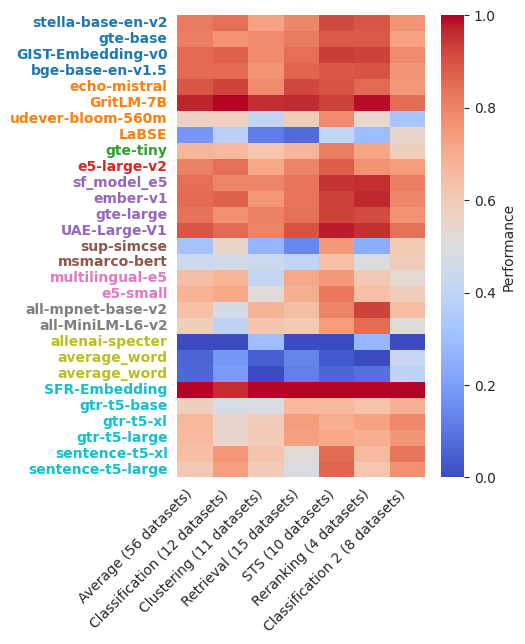

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram


perfs = pd.merge(mteb_info, pivoted_classif*100, left_index=True, right_index=True).dropna().drop(columns=METRIC)

communities = make_communities_from_table(table)
# apply short names
communities = {k.split('/')[-1] : v for k, v in communities.items()}
perfs['community'] = perfs.index.map(lambda x: communities[x])

perfs = perfs.sort_values('community')
_perfs = perfs.drop(columns='community')

# normalize _perfs columns by columns
# _perfs = (_perfs - _perfs.mean()) / _perfs.std()
_perfs = (_perfs - _perfs.min()) / (_perfs.max() - _perfs.min())

fig, ax = plt.subplots(figsize=(4, 6))
sns.heatmap(_perfs, ax=ax, annot=False, cmap='coolwarm', cbar_kws={'label': 'Performance'})

# color ytick labels by community
yticks = ax.get_yticklabels()
new_yticks = []
for i, ytick in enumerate(yticks):
    text = ytick.get_text()
    if len(text) > 20:
        if len(text.split('_')) > 1:
            text = "_".join(text.split('_')[:2])
        elif len(text.split('/')) > 1:
            text = "/".join(text.split('/')[:2])
        elif len(text.split('-')) > 1:
            text = "-".join(text.split('-')[:2])
            
    new_yticks.append(text)
    


ax.set_yticklabels(new_yticks)  

yticks = ax.get_yticklabels()

for i, ytick in enumerate(yticks):
    ytick.set_color(f"C{perfs['community'].iloc[i]}")
    # set fontweight to bold for the community name
    ytick.set_fontweight('bold')
    
# Remove \sAverage from the names
xticks = ax.get_xticklabels()
xticks = [re.sub(r'\sAverage', '', x.get_text()) for x in xticks]
ax.set_xticklabels(xticks, rotation=45, ha='right')
    
ax.set_ylabel('')

# path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_tasks_perfs_community_heatmap.pdf")
# # make sure the folder exists
# path.parent.mkdir(parents=True, exist_ok=True)
# # fig.tight_layout()
# fig.savefig(path, bbox_inches='tight', dpi=300)


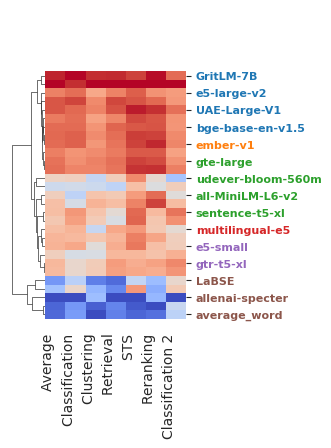

In [15]:

from scipy.cluster.hierarchy import linkage, dendrogram


perfs = pd.merge(mteb_info, pivoted_classif*100, left_index=True, right_index=True).dropna().drop(columns=METRIC)

communities = make_communities_from_table(table)
# apply short names
communities = {k.split('/')[-1] : v for k, v in communities.items()}
perfs['community'] = perfs.index.map(lambda x: communities[x])

perfs = perfs.sort_values('community')
_perfs = perfs.drop(columns='community')

# normalize _perfs columns by columns
# _perfs = (_perfs - _perfs.mean()) / _perfs.std()
_perfs = (_perfs - _perfs.min()) / (_perfs.max() - _perfs.min())

g = sns.clustermap(_perfs, annot=False, row_cluster=True, col_cluster=False, 
                   figsize=(5, 6), cmap='coolwarm')
g.cax.set_visible(False)
ax = g.ax_heatmap
# color ytick labels by community
yticks = ax.get_yticklabels()
new_yticks = []
for i, ytick in enumerate(yticks):
    text = ytick.get_text()
    if len(text) > 20:
        if len(text.split('_')) > 1:
            text = "_".join(text.split('_')[:2])
        elif len(text.split('/')) > 1:
            text = "/".join(text.split('/')[:2])
        elif len(text.split('-')) > 1:
            text = "-".join(text.split('-')[:2])

    new_yticks.append(text)



ax.set_yticklabels(new_yticks)

yticks = ax.get_yticklabels()

for i, ytick in enumerate(yticks):
    ytick.set_color(f"C{perfs['community'].iloc[i]}")
    # set fontweight to bold for the community name
    ytick.set_fontweight('bold')
    ytick.set_fontsize(8)

# Remove \sAverage from the names
xticks = ax.get_xticklabels()
xticks = [re.sub(r'\sAverage', '', x.get_text()) for x in xticks]
xticks = [re.sub(r'\(.*\)', '', x) for x in xticks]
ax.set_xticklabels(xticks, rotation=90, ha='right')

ax.set_ylabel('')

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_tasks_perfs_community_heatmap.pdf")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
# fig.tight_layout()
g.fig.savefig(path, bbox_inches='tight', dpi=300)



In [43]:
# Clustering based on the performance

from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=123)
clusters = kmeans.fit_predict(_perfs)

_perfs['cluster'] = clusters


_table = table.copy()
_table.index = table.index.map(lambda x: x.split('/')[-1])
_table.columns = table.columns.map(lambda x: x.split('/')[-1])

# take the intersection of the models
_table = _table.loc[_perfs.index, _perfs.index]

clusters


array([2, 8, 5, 7, 9, 2, 2, 2, 2, 2, 9, 9, 2, 2, 2, 2, 1, 1, 6, 0, 0, 3,
       3, 8, 1, 1, 1, 4, 4], dtype=int32)

In [45]:
_perfs

,Average (56 datasets),Classification Average (12 datasets),Clustering Average (11 datasets),Retrieval Average (15 datasets),STS Average (10 datasets),Reranking Average (4 datasets),Classification 2 (8 datasets),cluster
model,,,,,,,,
echo-mistral-7b-instruct-lasttoken,0.894428,0.925065,0.786853,0.919295,0.896380,0.855908,0.751154,2
GritLM-7B,0.970674,1.000000,0.957769,0.963126,0.929255,0.991354,0.851116,8
udever-bloom-560m,0.569282,0.578442,0.411155,0.586967,0.786933,0.536599,0.322415,5
LaBSE,0.180718,0.381691,0.118725,0.072124,0.406991,0.295677,0.543191,7
gte-tiny,0.674853,0.663714,0.618327,0.673469,0.808989,0.719308,0.584719,9
gte-base,0.810484,0.761905,0.782072,0.817718,0.885560,0.882997,0.727005,2
stella-base-en-v2,0.818548,0.845700,0.730279,0.793599,0.915522,0.892795,0.763188,2
GIST-Embedding-v0,0.858871,0.873385,0.782470,0.844852,0.935913,0.926801,0.788997,2
bge-base-en-v1.5,0.853006,0.854928,0.764940,0.866651,0.889721,0.897406,0.760083,2


/home/mdarrin/Documents/phd/transformers/EMIRR/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


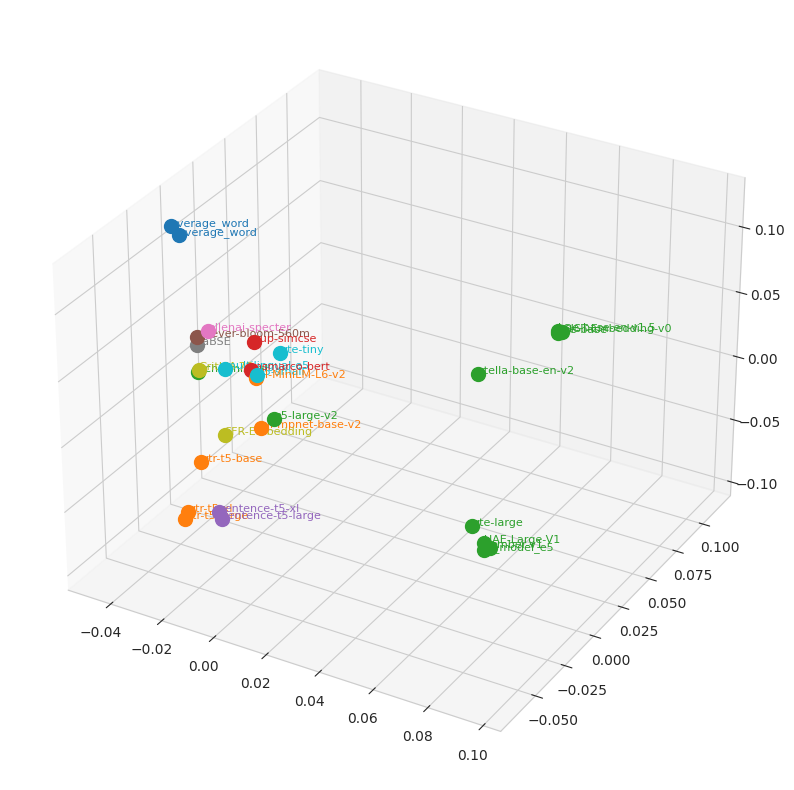

In [70]:

# background white
sns.set_style("whitegrid")

from adjustText import adjust_text

def shorten_more(text):
    if len(text) > 20:
        if len(text.split('_')) > 1:
            text = "_".join(text.split('_')[:2])
        elif len(text.split('/')) > 1:
            text = "/".join(text.split('/')[:2])
        elif len(text.split('-')) > 1:
            text = "-".join(text.split('-')[:2])

    return text

from sklearn.manifold import spectral_embedding

embedding = spectral_embedding(_table.values, n_components=3, random_state=123)

# make 3d plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# plot the points
for i, (x, y, z) in enumerate(embedding):
    ax.scatter(x, y, z, c=f"C{clusters[i]}", label=clusters[i], s=100)
    ax.text(x, y, z, shorten_more(_table.index[i]), color=f"C{clusters[i]}", fontsize=8)




    
    
    

